# Model Evaluation

## Import Modules

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

## RunParameters Class

In [2]:
class RunParameters:
    '''classe che gestisce i parametri della run'''
    
    def __init__(self, out_dir: str, ndir=0, ntoy=40, magic=0):
        '''init: imposto il nome della cartella di output, genero il nome della cartella contenente il file e cerco il file'''
        
        self.out_dir = out_dir
        self.folder_name = os.listdir(self.out_dir+f'/{magic}/')[ndir]
        self.fname = [name for name in os.listdir(self.out_dir+f'/{magic}/'+self.folder_name) if f'_toy{ntoy}_t.txt' in name][0]
        
        return
    
    def fetch_parameters(self) -> list:
        '''uso il nome del file e della cartella per estrarre i parametri della run'''
        
        self.check_point_t = int(self.fname.split("patience", 1)[1].split("_", 1)[0])
        self.toys = int(self.fname.split("toy", 1)[1].split("_", 1)[0])
        self.ref = (self.fname.split("_")[2]).split("ref")[1]
        self.bkg = (self.fname.split("_")[3]).split("bkg")[1]
        self.sig = (self.fname.split("_")[4]).split("sig")[1]
        self.w_clip = self.folder_name.split('wclip',1)[1]
        self.latent = int(self.folder_name.split("latent", 1)[1].split("_", 1)[0])
        self.layers = int(self.folder_name.split("layers", 1)[1].split("_", 1)[0])
        self.epochs = int(self.folder_name.split('epochs',1)[1].split('_')[0])
        
        self.parameters = [self.toys, self.w_clip, self.epochs, self.check_point_t, self.ref, self.bkg, self.sig, self.latent, self.layers]
        
        return self.parameters
    
    def print_parameters(self):
        '''stampo i parametri per controllare corrispondano alla run'''
        
        print('\nFolder name: ' + self.folder_name)
        print('File name: ' + self.fname)
        
        print(f'\nParameters:                                              \
                        \n Toys:          {self.toys}                      \
                        \n Latent space:  {self.latent}                    \
                        \n Layers:        {self.layers}                    \
                        \n W_clip:        {self.w_clip}                    \
                        \n Epochs:        {self.epochs}                    \
                        \n Check_point_t: {self.check_point_t}             \
                        \n Ref, Bkg, Sig: {self.ref} {self.bkg} {self.sig} \n'
             )
        
        return  
    
    def fetch_file(self) -> str:
        '''genero il nome completo del file contenente il t finale'''
        
        self.tfile = f'1D_patience{self.check_point_t}_ref{self.ref}_bkg{self.bkg}_sig{self.sig}\
        _epochs{self.epochs}_latent{self.latent}_layers{self.layers}_wclip{self.w_clip}\
        /1D_patience{self.check_point_t}_ref{self.ref}_bkg{self.bkg}_sig{self.sig}_toy{self.toys}_t.txt'
        
        self.tfile = self.tfile.replace(' ', '')
        
        return self.tfile
    
    def fetch_history(self) -> str:
        '''genero il nome completo del file contenente il t per ogni checkpoint'''
        
        self.thistory = f'1D_patience{self.check_point_t}_ref{self.ref}_bkg{self.bkg}_sig{self.sig}\
        _epochs{self.epochs}_latent{self.latent}_layers{self.layers}_wclip{self.w_clip}\
        /1D_patience{self.check_point_t}_ref{self.ref}_bkg{self.bkg}_sig{self.sig}_toy{self.toys}_history{self.check_point_t}.h5'
        
        self.thistory = self.thistory.replace(' ', '')
        
        return self.thistory

## T Distribution Class

In [57]:
class TDist:
    '''classe che gestisce la distribuzione dei t'''
    
    def __init__(self, dof, bins, toys, epochs, check_point_t, out_dir, tfile, thistory, save_flag):
        '''init: imposto parametri importanti della run e i file di interesse'''
        
        self.dof = dof
        self.bins = bins
        self.epochs = epochs
        self.check_point_t = check_point_t
        self.toys = toys
        self.OUT_PATH = out_dir
        self.OUT_FILE_t = tfile
        self.OUT_FILE_t_history = thistory
        self.save_flag = save_flag
        
        return
    
    
    def plotOutPath(self):
        path = '/lustre/cmswork/nlai/PLOTS/NPL_1D/MODEL_PREDICTION/'
        rPar = RunParameters(self.OUT_PATH, 0, self.toys)
        toys, w_clip, epochs, check_point_t, ref, bkg, sig, latent, layers = rPar.fetch_parameters()
        
        pngfile = f'1D_patience{check_point_t}_ref{ref}_bkg{bkg}_sig{sig}\
        _epochs{epochs}_latent{latent}_layers{layers}_wclip{w_clip}_toy{toys}'
        
        pngfile = pngfile.replace(' ', '')
        
        self.pngpath = path + pngfile
        
        return self.pngpath
    
    
    def getT(self):
        '''ciclo su tutti i file per prendere tutti i t e tutte le history'''
        
        self.t_list=[]
        self.t_list_history=[]
        counter=0
        preview=0
        for i in range(self.toys-preview):
            
            file_name = self.OUT_PATH + f'/{i}/' + self.OUT_FILE_t
            if os.path.isfile(file_name):
                f = open(file_name, "r")
                self.t_list.append(float(f.readline()[:-1]))
                f.close()
                #print(i)
                if np.logical_not(np.isnan(self.t_list[-1])):
                    counter += 1
                    
            history_name = self.OUT_PATH + f'/{i}/' + self.OUT_FILE_t_history
            if os.path.isfile(history_name):
                f = h5py.File(history_name, "r")
                try:
                    self.t_list_history.append(-2*np.array(f.get('loss')))
                except: print('Problem with toy ', i)
                f.close()
                
        self.t_list=np.array(self.t_list)
        self.t_list_history=np.array(self.t_list_history)
        
        print(f"\nToys at disposal/Total toys: {counter}/{self.toys-preview}")
        
        return 
    
    
    def computeMedian(self):
        '''calcolo la mediana per un rapido controllo di compatibilità'''
        
        median_t = np.median(self.t_list)
        print("\nMedian t distribution: ", median_t)
        
        p_list = np.sum([1/(len(self.t_list)) for x in self.t_list if x>median_t])
        
        print(
            f"Median p-value: {p_list :.4f}\
            Median significance: {scipy.stats.norm.ppf(1-p_list):.4f}\
            from t list"
        )
        
        print(
            f"Median p-value: {scipy.stats.chi2.sf(median_t, df=self.dof):.4f}\
            Median significance: {scipy.stats.norm.ppf(1-scipy.stats.chi2.sf(median_t, df=self.dof)):.4f}\
            from chi2 distribution" 
        ) 
        
        return
    
    
    def change_legend(self, ax, new_loc, fontsize, titlesize, **kws):
        '''funzione per modificare posizione e font size della legenda generata da seaborn'''

        old_legend = ax.legend_
        handles = old_legend.legendHandles
        labels = [t.get_text() for t in old_legend.get_texts()]
        title = old_legend.get_title().get_text()

        ax.legend(handles, labels, loc=new_loc, title=title, fontsize=fontsize, title_fontsize=titlesize, frameon = True, fancybox = False, framealpha = 0.5, **kws)
    
        return
    
    
    def plotterLayout(self, ax, title: str, titlefont: int, xlabel: str, ylabel: str, labelfont: int, xlimits=[], ylimits=[]):
        
        if xlimits:
            ax.set_xlim(xlimits[0], xlimits[1])
        if ylimits:
            ax.set_ylim(ylimits[0], ylimits[1])
            
        ax.set_title(title, fontsize=titlefont)
        
        ax.set_xlabel(xlabel, fontsize = labelfont)
        ax.set_ylabel(ylabel, fontsize = labelfont)
        
        # sistemo i ticks
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)
        
        return
    
    
    def plotTdist(self, train_dist):
        '''grafico della distribuzione dei t'''
        
        XMIN = 0
        if max(self.t_list) >= 3*self.dof:
            XMAX = max(self.t_list) + min(self.t_list) 
        elif max(self.t_list) < 3*self.dof:
            XMAX = 3*self.dof
            
        XLIM = [XMIN, XMAX]
            
        YMIN = 0
            
        XGRID = np.linspace(XMIN, XMAX, 500)
        BINS = self.bins
        
        self.tobs_pval = scipy.stats.chi2.sf(self.t_list[-1], df=self.dof)
        self.tobs_sig = scipy.stats.norm.ppf(1-self.tobs_pval)
    
        
        fig, ax = plt.subplots(figsize=(12,7))
        
        ax.axvline(x=self.t_list[-1], 
                   color='red', linestyle='solid', linewidth=5, alpha=0.6, 
                   label=f'tOBS: {self.t_list[-1]}')
        
        ax = sns.histplot(x=train_dist, bins=BINS, 
                          stat='density', element='bars', fill=True, color='#aadeff', edgecolor='#009cff', 
                          label='reference t distribution')
        
        hist, bin_edges = np.histogram(train_dist, density=True, bins=BINS)
        binswidth = bin_edges[1]-bin_edges[0]
        central_points = []
        for i in range(0, len(bin_edges)-1):
            half = (bin_edges[i] + bin_edges[i+1])/2
            central_points.append(half)
            
        err = np.sqrt(hist/(train_dist.shape[0]*binswidth))
    
        ax.errorbar(central_points, hist, yerr = err, color='#009cff', marker='o', ls='')
        
        ax.plot(XGRID,scipy.stats.chi2.pdf(XGRID, df=self.dof), 
                color='#009cff', linestyle='solid', linewidth=5, alpha=0.6, 
                label=f'theoretical t distribution, dof: {self.dof}')
        
        ax.text(x=0.65,y=0.65,s=( 'tOBS p-value = ' + format(self.tobs_pval,'1.5f') + '\ntOBS significance = ' + format(self.tobs_sig,'1.2f') + '\u03C3' ),
                fontsize=14, color='black', fontvariant='small-caps', transform=ax.transAxes)
        
        
        YMAX = max(hist)*1.2
        YLIM = [YMIN, YMAX]
        self.plotterLayout(ax=ax, xlimits=XLIM, ylimits=YLIM, title='tOBS with reference t distribution', titlefont=18, xlabel='t', ylabel='density', labelfont=16)
        
        ax.legend()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend([handles[idx] for idx in [2, 1, 0]], [labels[idx] for idx in [2, 1, 0]])
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
        if self.save_flag:
            fig.savefig(self.plotOutPath()+'_distribution.png', dpi = 300, facecolor='white')
        plt.show()
        
        print('tOBS p-value = ' + format(self.tobs_pval,'1.5f'))
        print('tOBS significance = ' + format(self.tobs_sig,'1.5f'))
        
        return 
    
    
    def plotThistory(self):
        '''grafico della storia dei t'''
        
        XMIN = 0
        XMAX = self.epochs
        
        YMIN = 0
        if max(self.t_list) >= 4*self.dof:
            YMAX = max(self.t_list) + min(self.t_list) 
        elif 3*self.dof <= max(self.t_list) < 4*self.dof:
            YMAX = 4.1*self.dof 
        elif max(self.t_list) < 3*self.dof:
            YMAX = 3*self.dof
            
        XLIM = [XMIN, XMAX]
        YLIM = [YMIN, YMAX]
        
        fig, ax = plt.subplots(figsize=(12,7))
        
        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % self.check_point_t == 0]
        
        ax.plot(x_tics[1:], self.t_list_history[0][1:], color='#009cff', linestyle='solid', linewidth=3, alpha=1)
            
        self.plotterLayout(ax=ax, xlimits=XLIM, ylimits=YLIM, title='t history', titlefont=18, xlabel='training epoch', ylabel='t', labelfont=16)
        
        fig.tight_layout()
        if self.save_flag:
            fig.savefig(self.plotOutPath()+'_history.png', dpi = 300, facecolor='white')
        plt.show()
        return
    
    
    def plotPvalToyHistory(self):
        
        
        self.pval = scipy.stats.chi2.sf(self.t_list_history[0][:], df=self.dof)
        
        XMIN = 0
        XMAX = self.epochs
        
        XLIM = [XMIN, XMAX]
        
        fig, ax = plt.subplots(figsize=(12,7))
        
        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % self.check_point_t == 0]
        
        ax.plot(x_tics[1:], self.pval[1:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
               label=f'final p-value: {self.pval[-1]:.5f}')
                               
        self.plotterLayout(ax=ax, xlimits=XLIM, title='pval history', titlefont=18, xlabel='training epoch', ylabel='p_value', labelfont=16)
        
        ax.legend()
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
        if self.save_flag:
            fig.savefig(self.plotOutPath()+'_pval_history.png', dpi = 300, facecolor='white')
        plt.show()
        return
  
    
    def plotSignificanceToyHistory(self):
        '''grafico della storia della significanza per ogni toy'''
        
        
        self.Z = scipy.stats.norm.ppf(1-self.pval[:])
        XMIN = 0
        XMAX = self.epochs
        
        XLIM = [XMIN, XMAX]
        
        fig, ax = plt.subplots(figsize=(12,7))
        
        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % self.check_point_t == 0]
        
        ax.plot(x_tics[1:], self.Z[1:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
               label=f'final Z: {self.Z[-1]:.5f}')
        
        
        
        '''cercare di aumentare la sensibilità della significanza!!!'''
#         for i in range(len(self.t_list_history)):
#             ax.plot(x_tics[1:],scipy.stats.norm.ppf(1.0-scipy.stats.chi2.sf(self.t_list_history[i][1:], df=self.dof)))
#             # pvalue
#             print('Pval')
#             print( np.array( scipy.stats.chi2.sf(self.t_list_history[i][1:], df=self.dof ), dtype=np.float128 ) )
#             print('Pval - cdf')
#             print(scipy.stats.chi2.cdf(self.t_list_history[i][1:], df=self.dof))
#             print('Differenza')
#             print(  scipy.stats.norm.ppf(np.ones( len(self.t_list_history[i][1:]), dtype=np.float128 ) - np.array(scipy.stats.chi2.sf(self.t_list_history[i][1:], df=self.dof), dtype=np.float128) ))
#             print('Significance')
#             print(scipy.stats.norm.ppf(1-scipy.stats.chi2.sf(self.t_list_history[i][1:], df=self.dof)))
            
        self.plotterLayout(ax=ax, xlimits=XLIM, title='significance history', titlefont=18, xlabel='training epoch', ylabel='Z', labelfont=16)
        
        ax.legend()
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
        if self.save_flag:
            fig.savefig(self.plotOutPath()+'_significance_history.png', dpi = 300, facecolor='white')
        plt.show()
        return
    
    

def getTtrain():
    WCLIP = 7
    NTOYS = 150
    EPOCHS = '200k'
    JOB = 'hstat' # 'hstat'
    TOY_TEST = 0
    DATA_FOLDER = '/lustre/cmswork/nlai/NPL_1D/MODEL_SELECTION/'
    OUT_PATH = DATA_FOLDER+f'E{EPOCHS}W{WCLIP}_{JOB}'
    DOF = 10
    NFOLDER = 0
    SAVE_FIG = 0
    
    rPar = RunParameters(OUT_PATH, NFOLDER, NTOYS, TOY_TEST)
    toys, w_clip, epochs, check_point_t, ref, bkg, sig, latent, layers = rPar.fetch_parameters()
#     rPar.print_parameters()

    OUT_FILE_t = rPar.fetch_file()
    OUT_FILE_t_history = rPar.fetch_history()
    tTrain = TDist(DOF, BINS, toys, epochs, check_point_t, OUT_PATH, OUT_FILE_t, OUT_FILE_t_history, SAVE_FIG)
    tTrain.getT()
    return tTrain.t_list

## Check Run Parameters

In [67]:
WCLIP = 7 # MODIFY THIS FOR CHANGING DIRECTORY
NTOYS = 1

EPOCHS = '100k'
SIGNAL = 50
JOB = 'predict' # 'hstat'
TOY_TEST = 0

DATA_FOLDER = '/lustre/cmswork/nlai/NPL_1D/MODEL_PREDICTION/'
OUT_PATH = DATA_FOLDER+f'E{EPOCHS}W{WCLIP}s{SIGNAL}_{JOB}'
DOF = 10
NFOLDER = 0

rPar = RunParameters(OUT_PATH, NFOLDER, NTOYS, TOY_TEST)
toys, w_clip, epochs, check_point_t, ref, bkg, sig, latent, layers = rPar.fetch_parameters()
rPar.print_parameters()

OUT_FILE_t = rPar.fetch_file()
OUT_FILE_t_history = rPar.fetch_history()


Folder name: 1D_patience1000_ref100000_bkg10000_sig50_epochs100000_latent3_layers1_wclip7.0
File name: 1D_patience1000_ref100000_bkg10000_sig50_toy1_t.txt

Parameters:                                                                      
 Toys:          1                                              
 Latent space:  3                                            
 Layers:        1                                            
 W_clip:        7.0                                            
 Epochs:        100000                                            
 Check_point_t: 1000                                     
 Ref, Bkg, Sig: 100000 10000 50 



## Model Analysis

In [68]:
BINS = 10
SAVE_FIG = 0

tDist = TDist(DOF, BINS, toys, epochs, check_point_t, OUT_PATH, OUT_FILE_t, OUT_FILE_t_history, SAVE_FIG)
tDist.getT()
tDist.computeMedian()


Toys at disposal/Total toys: 1/1

Median t distribution:  207.950287
Median p-value: 0.0000            Median significance: inf            from t list
Median p-value: 0.0000            Median significance: inf            from chi2 distribution



Toys at disposal/Total toys: 150/150


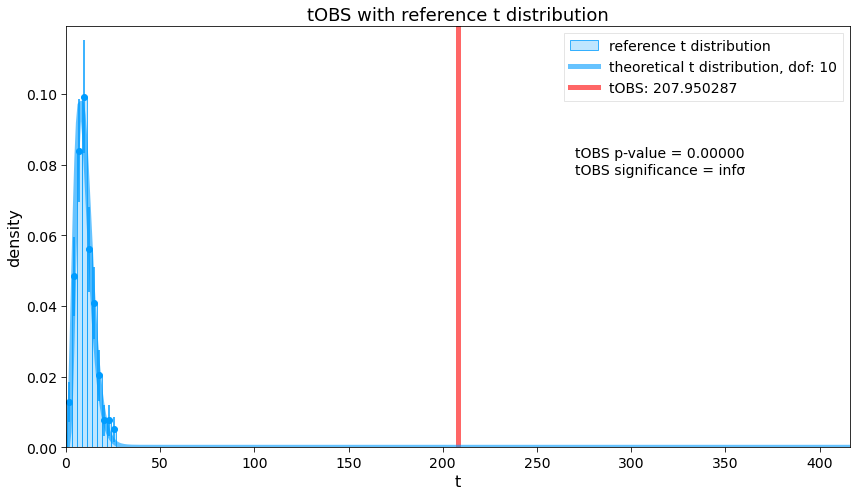

tOBS p-value = 0.00000
tOBS significance = inf


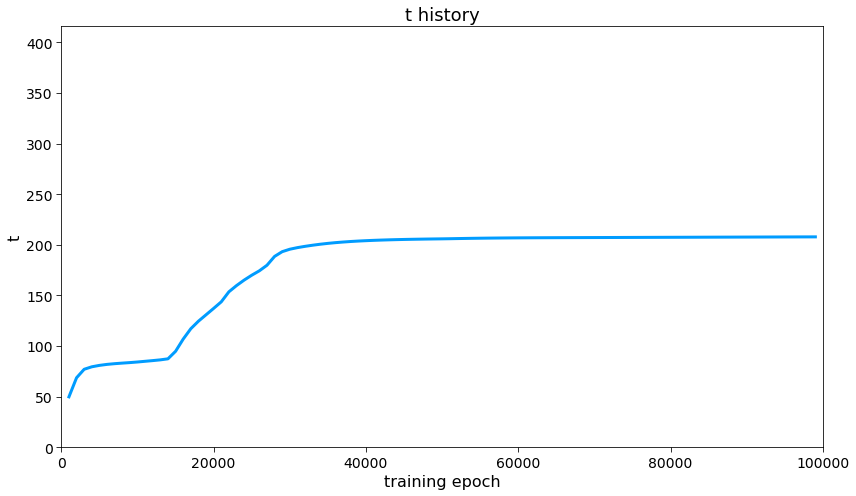

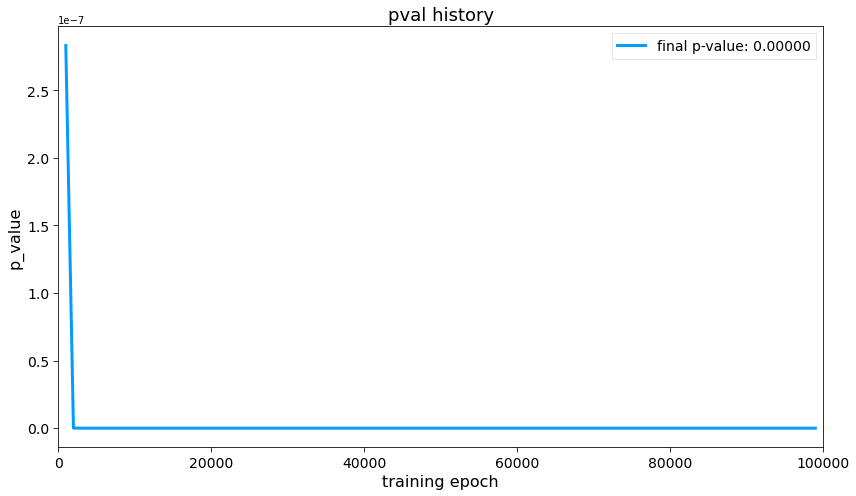

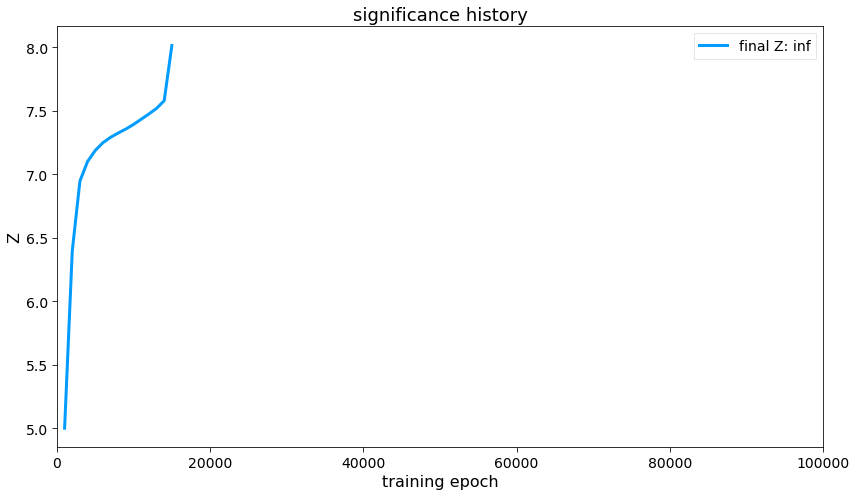

In [69]:
tDist.plotTdist(getTtrain())
tDist.plotThistory()
tDist.plotPvalToyHistory()
tDist.plotSignificanceToyHistory()